### Импорты

In [10]:

import torch.nn as nn
import os
from config import PATHS, TRAINING_CONFIG, MODEL_CONFIG
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch.optim as optim
import numpy as np
import zipfile
import tarfile
import requests
import json
from datetime import datetime
from collections import Counter
import torchvision.models as models
import torch.nn.functional as F
import seaborn as sns
import pandas as pd


### Загрузка и предобработка данных

In [2]:
# Скачивание и подготовка данных

def download_from_yandex_disk(public_url: str, save_path: str):
    """Скачивает файл с Яндекс.Диска"""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    try:
        download_url = f"https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={public_url}"
        response = requests.get(download_url)
        
        if response.status_code == 200:
            href = response.json().get('href')
            if href:
                file_response = requests.get(href, stream=True)
                file_response.raise_for_status()
                
                total_size = int(file_response.headers.get('content-length', 0))
                downloaded = 0
                
                with open(save_path, 'wb') as f:
                    for chunk in file_response.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
                            downloaded += len(chunk)
                            if total_size:
                                percent = (downloaded / total_size) * 100
                                print(f"\rПрогресс: {percent:.1f}%", end='')
                
                print(f"\nФайл сохранён: {save_path}")
                return True
        return False
    except Exception as e:
        print(f"Ошибка: {e}")
        return False

def extract_archive(archive_path: str, extract_to: str):
    """Разархивирует файл"""
    os.makedirs(extract_to, exist_ok=True)
    archive_path = Path(archive_path)
    
    try:
        if archive_path.suffix == '.zip':
            with zipfile.ZipFile(archive_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
        elif archive_path.suffix in ['.tar', '.gz', '.tgz'] or '.tar.' in archive_path.name:
            mode = 'r:gz' if archive_path.suffix in ['.gz', '.tgz'] else 'r:bz2' if archive_path.suffix == '.bz2' else 'r'
            with tarfile.open(archive_path, mode) as tar_ref:
                tar_ref.extractall(extract_to)
        else:
            return False
            
        print(f"Данные разархивированы в: {extract_to}")
        return True
    except Exception as e:
        print(f"Ошибка разархивирования: {e}")
        return False

# Запуск скачивания и разархивирования
url = "https://disk.yandex.ru/d/o4oQ4Yk7SpH1dw"
archive_path = PATHS['raw_data']
extract_path = PATHS['extracted_data']

print("Начинаем скачивание данных...")
if download_from_yandex_disk(url, archive_path):
    print("\nНачинаем разархивирование...")
    if extract_archive(archive_path, extract_path):
        print("\nДанные скачаны и разархивированы")

Начинаем скачивание данных...


Прогресс: 100.0%
Файл сохранён: /home/ubuntu/pill_classification/dataset/raw_dataset.zip

Начинаем разархивирование...
Данные разархивированы в: /home/ubuntu/pill_classification/dataset/extracted

Данные скачаны и разархивированы


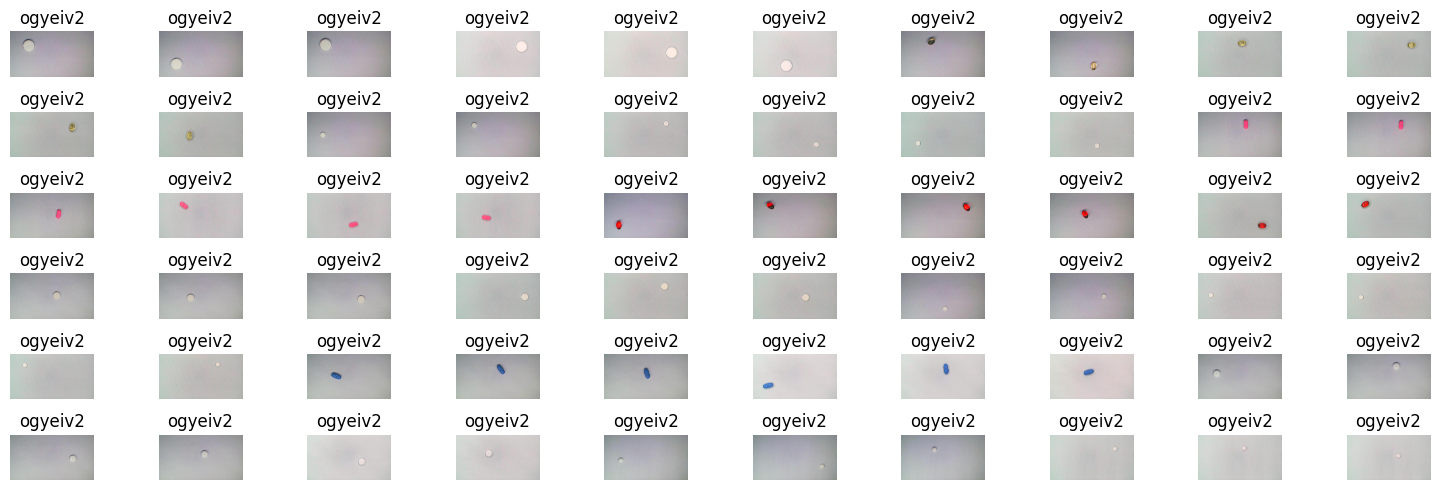

In [3]:
# Загрузка датасета
dataset_path = PATHS['extracted_data']
dataset = ImageFolder(dataset_path)


fig, axes = plt.subplots(6, 10, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    image, label = dataset[i]
    ax.imshow(image)
    ax.set_title(dataset.classes[label])
    ax.axis('off')
plt.tight_layout()
plt.show()


Опытным путем было проверено, что для для достижения более-менее успешных результатов (т.к. у нас в датасете имеются очень похожие визуально таблетки), нужна довольно сильная аугментация.

In [4]:
def get_transforms():
    """
    Возвращает трансформации для обучающей и валидационной выборок
    С усиленной аугментацией для малого датасета. Опытным путем было вычислено, что это приводит к лучшим результатам
    """
    train_transform = transforms.Compose([
        # Resize с запасом для crop
        transforms.Resize((256, 256)),
        
        # Случайный crop (добавляет вариативность)
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        
        # Геометрические трансформации
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(30),  
        transforms.RandomAffine(
            degrees=0, 
            translate=(0.1, 0.1),  # Сдвиги
            scale=(0.9, 1.1)        # Масштаб
        ),
        
        # Цветовые трансформации (важно для различения похожих таблеток)
        transforms.ColorJitter(
            brightness=0.4,  
            contrast=0.4,    
            saturation=0.3,  
            hue=0.1          
        ),
        
        # Размытие (имитация некачественного фото)
        transforms.RandomApply([
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
        ], p=0.2),
        
        # Перспектива (имитация съёмки под углом)
        transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
        
        # Конвертация в тензор
        transforms.ToTensor(),
        
        # Нормализация (ImageNet статистика)
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        ),
        
        # Random Erasing (случайное стирание части изображения - последний шаг!)
        transforms.RandomErasing(
            p=0.3, 
            scale=(0.02, 0.15),
            ratio=(0.3, 3.3)
        )
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    return train_transform, val_transform


def create_dataloaders(extracted_path, batch_size=32, val_split=0.2, random_seed=42):
    """
    Создаёт DataLoader для обучающей и валидационной выборок
    
    Структура данных:
    train/
      ├── urzinol/
      │   ├── urzinol_s_025.jpg
      │   └── ...
      ├── strepsils/
      │   ├── strepsils_020.jpg
      │   └── ...
      └── ...
    Названием класса является название папки!
    Args:
        extracted_path: путь к папке с данными
        batch_size: размер батча
        val_split: доля валидационной выборки (от 0 до 1)
        random_seed: seed для воспроизводимости
    """
    extracted_path = Path(extracted_path)
    
    # Путь к папке train
    train_dir = extracted_path / 'ogyeiv2' / 'train'
    
    # Проверяем существование директории
    if not train_dir.exists():
        raise FileNotFoundError(f"Директория не найдена: {train_dir}")
    
    # Получаем трансформации
    train_transform, val_transform = get_transforms()
    
    # ImageFolder автоматически определяет классы по названиям папок
    # Структура: train/class_name/image.jpg
    full_dataset = datasets.ImageFolder(root=train_dir)
    
    # Выводим найденные классы
    print(f"Найдено классов: {len(full_dataset.classes)}")
    print(f"Классы: {full_dataset.classes[:10]}...") 
    
    # Разделяем на train и val
    total_size = len(full_dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    
    train_indices, val_indices = random_split(
        range(total_size),
        [train_size, val_size],
        generator=torch.Generator().manual_seed(random_seed)
    )
    
    # Создаём отдельные датасеты с разными трансформациями
    train_dataset = torch.utils.data.Subset(
        datasets.ImageFolder(root=train_dir, transform=train_transform),
        train_indices.indices
    )
    
    val_dataset = torch.utils.data.Subset(
        datasets.ImageFolder(root=train_dir, transform=val_transform),
        val_indices.indices
    )
    
    # Получаем классы
    classes = full_dataset.classes
    
    # Создаём DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    return train_loader, val_loader, classes


if __name__ == "__main__":
    # Путь к разархивированным данным
    extracted_path = PATHS['extracted_data']
    
    # Создаём DataLoader (80% train, 20% val)
    train_loader, val_loader, classes = create_dataloaders(
        extracted_path=extracted_path,
        batch_size=32,
        val_split=0.2,
        random_seed=42
    )
    
    # Выводим информацию
    num_classes = len(classes)
    num_train_images = len(train_loader.dataset)
    num_val_images = len(val_loader.dataset)
    
    
    print(f"Количество классов: {num_classes}")
    print(f"\nПримеры классов (первые 20):")
    for i, class_name in enumerate(classes[:20], 1):
        print(f"  {i}. {class_name}")
    if num_classes > 20:
        print(f"  ... и ещё {num_classes - 20} классов")
    
    print(f"\nКоличество изображений в train: {num_train_images}")
    print(f"Количество изображений в val: {num_val_images}")
    print(f"\nКоличество батчей в train_loader: {len(train_loader)}")
    print(f"Количество батчей в val_loader: {len(val_loader)}")
    print("="*50)
    
    # Проверяем один батч
    images, labels = next(iter(train_loader))
   
    print(f"  Размер батча изображений: {images.shape}")
    print(f"  Размер батча меток: {labels.shape}")
    print(f"  Примеры меток в батче: {labels[:5].tolist()}")

Найдено классов: 84
Классы: ['acc_long_600_mg', 'advil_ultra_forte', 'akineton_2_mg', 'algoflex_forte_dolo_400_mg', 'algoflex_rapid_400_mg', 'algopyrin_500_mg', 'ambroxol_egis_30_mg', 'apranax_550_mg', 'aspirin_ultra_500_mg', 'atoris_20_mg']...
Количество классов: 84

Примеры классов (первые 20):
  1. acc_long_600_mg
  2. advil_ultra_forte
  3. akineton_2_mg
  4. algoflex_forte_dolo_400_mg
  5. algoflex_rapid_400_mg
  6. algopyrin_500_mg
  7. ambroxol_egis_30_mg
  8. apranax_550_mg
  9. aspirin_ultra_500_mg
  10. atoris_20_mg
  11. atorvastatin_teva_20_mg
  12. betaloc_50_mg
  13. bila_git
  14. c_vitamin_teva_500_mg
  15. calci_kid
  16. cataflam_50_mg
  17. cataflam_dolo_25_mg
  18. cetirizin_10_mg
  19. cold_fx
  20. coldrex
  ... и ещё 64 классов

Количество изображений в train: 1882
Количество изображений в val: 470

Количество батчей в train_loader: 59
Количество батчей в val_loader: 15


  Размер батча изображений: torch.Size([32, 3, 224, 224])
  Размер батча меток: torch.Size([32])
  Примеры меток в батче: [31, 13, 5, 41, 45]


### Отдельно тест лоадер

In [5]:
#  Создание test_loader


def get_test_transform():
    """
    Трансформация для тестовых данных (без аугментации)
    """
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    return test_transform

# Путь к тестовым данным
test_dir = Path(PATHS['extracted_data']) / 'ogyeiv2' / 'test'

# Проверяем существование директории
if not test_dir.exists():
    raise FileNotFoundError(f"Директория не найдена: {test_dir}")

# Создаём тестовый датасет
test_transform = get_test_transform()
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Создаём test_loader
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Выводим информацию

print(f"Количество классов: {len(test_dataset.classes)}")
print(f"Количество изображений в test: {len(test_dataset)}")
print(f"Количество батчей в test_loader: {len(test_loader)}")

# Проверяем один батч
images, labels = next(iter(test_loader))

print(f"  Размер батча изображений: {images.shape}")
print(f"  Размер батча меток: {labels.shape}")
print(f"  Примеры меток в батче: {labels[:5].tolist()}")
print("="*50)


Количество классов: 84
Количество изображений в test: 504
Количество батчей в test_loader: 16


  Размер батча изображений: torch.Size([32, 3, 224, 224])
  Размер батча меток: torch.Size([32])
  Примеры меток в батче: [0, 0, 0, 0, 0]


In [6]:
# Проверим распределение классов

all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.numpy())

class_counts = Counter(all_labels)
print(f"Количество классов: {len(test_dataset.classes)}")
print(f"Всего изображений: {len(all_labels)}")
print(f"Минимум на класс: {min(class_counts.values())}")
print(f"Максимум на класс: {max(class_counts.values())}")
print(f"Среднее на класс: {sum(class_counts.values())/len(class_counts):.1f}")

KeyboardInterrupt: 

Данных мало, сами не обучим, возьмем готовое что-то хорошее (это будет EfficientNetB4) и дообучим с разморозкой 3 слоев.

### Объявление модели

In [7]:
# Определение устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

Используется устройство: cuda


In [8]:

# Создаём необходимые директории
os.makedirs(PATHS['models_dir'], exist_ok=True)
os.makedirs(PATHS['results_dir'], exist_ok=True)

Также было определено, что самая эффективная статья с нашими данными - это EfficientNet. Срзу вводим борьбу с перееобучением, так как разрыв между Val loss и train loss в некоторых экспериментах доходил до 20 и даже больше. Также получаются лучшие результаты не только при размораживании одной классификаонной головы, а еще нескольких слоев. Результаты сравнимы с трансформером ViT.

In [11]:


class PillClassifierEfficientNetB4(nn.Module):
    """
    EfficientNet-B4 с усиленной регуляризацией для борьбы с переобучением
    """
    def __init__(self, config):
        super().__init__()
        
        # Загружаем pretrained EfficientNet-B4
        self.backbone = models.efficientnet_b4(
            weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1
        )
        
        # Замораживаем все слои backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Размораживаем последние N блоков для fine-tuning
        total_blocks = len(self.backbone.features)
        unfreeze_from = total_blocks - config['unfreeze_last_n_blocks']
        
        for i in range(unfreeze_from, total_blocks):
            for param in self.backbone.features[i].parameters():
                param.requires_grad = True
        
        print(f"Заморожено блоков: {unfreeze_from}/{total_blocks}")
        print(f"Разморожено блоков: {total_blocks - unfreeze_from}/{total_blocks}")
        
        # Заменяем classifier с СИЛЬНОЙ регуляризацией
        num_features = self.backbone.classifier[1].in_features
        hidden_dims = config['classifier_hidden_dims']
        dropouts = config['classifier_dropouts']
        
        layers = []
        in_features = num_features
        
        # Создаем скрытые слои
        for i, (hidden_dim, dropout) in enumerate(zip(hidden_dims, dropouts[:-1])):
            layers.extend([
                nn.Dropout(dropout),
                nn.Linear(in_features, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU()
            ])
            in_features = hidden_dim
        
        # Финальный слой
        layers.extend([
            nn.Dropout(dropouts[-1]),
            nn.Linear(in_features, config['num_classes'])
        ])
        
        self.backbone.classifier = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.backbone(x)


# Создание модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}\n")

model = PillClassifierEfficientNetB4(config=MODEL_CONFIG).to(device)

# Подсчёт параметров
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\n{'='*60}")
print("АРХИТЕКТУРА МОДЕЛИ")
print(f"{'='*60}")
print(f"Модель: EfficientNet-B4")
print(f"Всего параметров:      {total_params:,}")
print(f"Обучаемых параметров:  {trainable_params:,}")
print(f"Замороженных:          {frozen_params:,}")
print(f"Процент обучаемых:     {trainable_params/total_params*100:.1f}%")
print(f"{'='*60}")

# Оптимизатор с СИЛЬНОЙ регуляризацией
criterion = nn.CrossEntropyLoss(label_smoothing=MODEL_CONFIG['label_smoothing'])

optimizer = optim.AdamW(
    model.parameters(),
    lr=MODEL_CONFIG['learning_rate'],
    weight_decay=MODEL_CONFIG['weight_decay'],
    betas=MODEL_CONFIG['betas']
)

# Scheduler для плавного снижения LR
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=MODEL_CONFIG['scheduler_T_max'],
    eta_min=MODEL_CONFIG['scheduler_eta_min']
)

print("\nПАРАМЕТРЫ ОБУЧЕНИЯ")
print(f"{'='*60}")
print(f"Loss Function:      CrossEntropyLoss (label_smoothing={MODEL_CONFIG['label_smoothing']})")
print(f"Optimizer:          AdamW")
print(f"Learning Rate:      {MODEL_CONFIG['learning_rate']:.6f}")
print(f"Weight Decay:       {MODEL_CONFIG['weight_decay']:.2f}")
print(f"Scheduler:          CosineAnnealingLR")

Используется устройство: cuda



Заморожено блоков: 6/9
Разморожено блоков: 3/9

АРХИТЕКТУРА МОДЕЛИ
Модель: EfficientNet-B4
Всего параметров:      19,679,612
Обучаемых параметров:  16,043,628
Замороженных:          3,635,984
Процент обучаемых:     81.5%

ПАРАМЕТРЫ ОБУЧЕНИЯ
Loss Function:      CrossEntropyLoss (label_smoothing=0.15)
Optimizer:          AdamW
Learning Rate:      0.001000
Weight Decay:       0.05
Scheduler:          CosineAnnealingLR


### Обучение и репорт результатов

In [12]:
# Цикл обучения с мониторингом переобучения и Early Stopping



# История обучения
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'gap': [],
    'lr': []
}

# Параметры из конфига
EPOCHS = TRAINING_CONFIG['epochs']
patience_limit = TRAINING_CONFIG['patience_limit']
log_interval = TRAINING_CONFIG['log_batch_interval']

best_val_acc = 0.0
best_val_loss = float('inf')
best_gap = float('inf')
patience = 0

print(f"\n{'='*60}")
print("ОБУЧЕНИЕ EfficientNet-B4")
print(f"{'='*60}")
print(f"Начало: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Эпох: {EPOCHS}")
print(f"Early Stopping: {patience_limit} эпох")
print(f"{'='*60}\n")

for epoch in range(EPOCHS):
    print(f"{'='*60}")
    print(f"Эпоха {epoch+1}/{EPOCHS}")
    print(f"{'='*60}")
    
    # ОБУЧЕНИЕ 
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Промежуточный вывод каждые N батчей
        if (batch_idx + 1) % log_interval == 0:
            batch_acc = 100 * correct / total
            print(f"  Батч {batch_idx+1}/{len(train_loader)}: "
                  f"Loss={loss.item():.4f}, Acc={batch_acc:.2f}%")
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    # ВАЛИДАЦИЯ 
    model.eval()
    running_vloss = 0.0
    vcorrect = 0
    vtotal = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_vloss += loss.item()
            _, predicted = torch.max(outputs, 1)
            vtotal += labels.size(0)
            vcorrect += (predicted == labels).sum().item()
    
    val_loss = running_vloss / len(val_loader)
    val_acc = 100 * vcorrect / vtotal
    
    # МЕТРИКИ 
    gap = train_acc - val_acc
    current_lr = optimizer.param_groups[0]['lr']
    
    # Сохранение истории
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['gap'].append(gap)
    history['lr'].append(current_lr)
    
    # Обновление Learning Rate
    scheduler.step()
    
    # ВЫВОД 
    gap_status = "Переобучения нет или почти нет" if gap < 10 else "На переобучение надо обратить внимания" if gap < 15 else "Переобучение критическое"
    
    print(f"\n{'─'*60}")
    print(f"ИТОГИ ЭПОХИ {epoch+1}")
    print(f"{'─'*60}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"{gap_status} Gap:      {gap:.2f}%")
    print(f"Learning Rate: {current_lr:.7f}")
    
    # СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ
    improved = False
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_gap = gap
        patience = 0
        improved = True
        
        model_path = os.path.join(PATHS['models_dir'], TRAINING_CONFIG['model_filename'])
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'gap': gap,
            'history': history
        }, model_path)
        
        print(f"Лучшая модель сохранена")
        print(f"Val Acc: {val_acc:.2f}%, Gap: {gap:.2f}%")
    
    elif val_acc == best_val_acc and gap < best_gap:
        
        best_gap = gap
        patience = 0
        improved = True
        
        model_path = os.path.join(PATHS['models_dir'], TRAINING_CONFIG['model_filename'])
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'val_acc': val_acc,
            'gap': gap
        }, model_path)
        
        print(f"Лучшая модель сохранена")
        print(f"Val Acc: {val_acc:.2f}%, Gap: {gap:.2f}%")
    
    else:
        patience += 1
        print(f"Без улучшений: {patience}/{patience_limit}")
    
    # EARLY STOPPING 
    if patience >= patience_limit:
        print(f"\n{'='*60}")
        print(f"EARLY STOPPING на эпохе {epoch+1}")
        print(f"Нет улучшений {patience_limit} эпох подряд")
        print(f"{'='*60}")
        break
    
    
    
    print()

# ИТОГИ ОБУЧЕНИЯ 
print(f"\n{'='*60}")
print("ОБУЧЕНИЕ ЗАВЕРШЕНО")
print(f"{'='*60}")
print(f"Окончание: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Обучено эпох: {len(history['train_acc'])}")
print(f"\nЛУЧШИЕ РЕЗУЛЬТАТЫ:")
print(f"  Val Accuracy:  {best_val_acc:.2f}%")
print(f"  Val Loss:      {best_val_loss:.4f}")
print(f"  Gap:           {best_gap:.2f}%")

print(f"\nМодель сохранена: {PATHS['models_dir']}/{TRAINING_CONFIG['model_filename']}")


ОБУЧЕНИЕ EfficientNet-B4
Начало: 2025-10-17 20:48:23
Эпох: 40
Early Stopping: 30 эпох

Эпоха 1/40


  Батч 10/59: Loss=4.5404, Acc=0.62%
  Батч 20/59: Loss=4.4961, Acc=1.09%
  Батч 30/59: Loss=4.3408, Acc=1.56%
  Батч 40/59: Loss=4.2607, Acc=1.64%
  Батч 50/59: Loss=4.2163, Acc=2.06%

────────────────────────────────────────────────────────────
ИТОГИ ЭПОХИ 1
────────────────────────────────────────────────────────────
Train Loss: 4.4484 | Train Acc: 2.39%
Val Loss:   4.0443 | Val Acc:   10.85%
Переобучения нет или почти нет Gap:      -8.46%
Learning Rate: 0.0010000
Лучшая модель сохранена
Val Acc: 10.85%, Gap: -8.46%

Эпоха 2/40


KeyboardInterrupt: 

### Test-Time Augmentation может улушить метрики на тесте

In [13]:
# Тестирование модели БЕЗ TTA 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загружаем лучшую модель
model_path = os.path.join(PATHS['models_dir'], 'meds_classifier.pt')

if not os.path.exists(model_path):
    print(f"Модель не найдена: {model_path}")
 
else:
    # Загрузка модели
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f" Модель загружена")
    print(f"  Эпоха: {checkpoint['epoch']}")
    print(f"  Val Accuracy: {checkpoint['val_acc']:.2f}%")
    print(f"  Gap: {checkpoint['gap']:.2f}%\n")
    
    print("="*60)
    print("ТЕСТИРОВАНИЕ БЕЗ TTA")
    print("="*60)
    
    labels_predicted = []
    labels_true = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            labels_predicted.extend(predicted.cpu().numpy())
            labels_true.extend(labels.numpy())
            
            if (batch_idx + 1) % 5 == 0:
                print(f"Обработано батчей: {batch_idx + 1}/{len(test_loader)}")
    
    # Метрики
    test_accuracy_baseline = accuracy_score(labels_true, labels_predicted)
    
    print(f"\n{'='*60}")
    print(f"РЕЗУЛЬТАТЫ БЕЗ TTA")
    print(f"{'='*60}")
    print(f"Test Accuracy: {test_accuracy_baseline*100:.2f}%")
    

 Модель загружена
  Эпоха: 0
  Val Accuracy: 10.85%
  Gap: -8.46%

ТЕСТИРОВАНИЕ БЕЗ TTA
Обработано батчей: 5/16
Обработано батчей: 10/16
Обработано батчей: 15/16

РЕЗУЛЬТАТЫ БЕЗ TTA
Test Accuracy: 11.71%


In [14]:
# Тестирование С TTA


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

print("="*60)
print("ТЕСТИРОВАНИЕ С TTA (4 АУГМЕНТАЦИИ - подобрано опытным путём)")
print("="*60)
print("Применяем аугментации:")
print("Оригинал")
print("Horizontal flip")
print("Vertical flip")
print("Both flips\n")

labels_predicted_tta = []
labels_true_tta = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        batch_predictions = []
        
        # 1. Оригинал
        imgs = images.to(device)
        outputs = model(imgs)
        probs = F.softmax(outputs, dim=1)
        batch_predictions.append(probs.cpu().numpy())
        
        # 2. Horizontal flip
        imgs_hflip = torch.flip(images, dims=[3]).to(device)
        outputs = model(imgs_hflip)
        probs = F.softmax(outputs, dim=1)
        batch_predictions.append(probs.cpu().numpy())
        
        # 3. Vertical flip
        imgs_vflip = torch.flip(images, dims=[2]).to(device)
        outputs = model(imgs_vflip)
        probs = F.softmax(outputs, dim=1)
        batch_predictions.append(probs.cpu().numpy())
        
        # 4. Both flips
        imgs_both = torch.flip(images, dims=[2, 3]).to(device)
        outputs = model(imgs_both)
        probs = F.softmax(outputs, dim=1)
        batch_predictions.append(probs.cpu().numpy())
        
        # Усредняем все 4 предсказания
        avg_probs = np.mean(batch_predictions, axis=0)
        predicted = np.argmax(avg_probs, axis=1)
        
        labels_predicted_tta.extend(predicted)
        labels_true_tta.extend(labels.numpy())
        
        if (batch_idx + 1) % 5 == 0:
            print(f"Обработано: {batch_idx + 1}/{len(test_loader)}")

# Метрики
test_accuracy_tta = accuracy_score(labels_true_tta, labels_predicted_tta)

print(f"\n{'='*60}")
print(f"СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print(f"{'='*60}")
print(f"БЕЗ TTA:  {test_accuracy_baseline*100:.2f}%")
print(f"С TTA:    {test_accuracy_tta*100:.2f}%")
print(f"{'='*60}")
print(f"Улучшение: {(test_accuracy_tta - test_accuracy_baseline)*100:+.2f}%")



# Подробный отчёт
print("Classification Report С TTA:\n")
print(classification_report(labels_true_tta, labels_predicted_tta, 
                          target_names=classes, digits=3))

ТЕСТИРОВАНИЕ С TTA (4 АУГМЕНТАЦИИ - подобрано опытным путём)
Применяем аугментации:
Оригинал
Horizontal flip
Vertical flip
Both flips



Обработано: 5/16
Обработано: 10/16


KeyboardInterrupt: 

In [15]:
# Сохранение результатов

os.makedirs(PATHS['results_dir'], exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Результаты
results = {
    'model': 'EfficientNet-B4',
    'timestamp': timestamp,
    'validation': {
        'val_accuracy': float(checkpoint['val_acc']),
        'val_loss': float(checkpoint['val_loss']),
        'gap': float(checkpoint['gap'])
    },
    'test_baseline': {
        'accuracy': float(test_accuracy_baseline * 100),
        'method': 'Single prediction'
    },
    'test_tta': {
        'accuracy': float(test_accuracy_tta * 100),
        'method': 'TTA (4 augmentations)',
        'augmentations': ['original', 'h_flip', 'v_flip', 'both_flips']
    },
    'improvement': {
        'tta_boost': float((test_accuracy_tta - test_accuracy_baseline) * 100)
    },
    'goal_achieved': test_accuracy_tta >= 0.75,
    'dataset': {
        'num_classes': len(classes),
        'test_samples': len(labels_true_tta)
    }
}

# Сохранение
results_path = os.path.join(PATHS['results_dir'], 'meds_classifier.json')
with open(results_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=4, ensure_ascii=False)

print(f"Результаты сохранены: {results_path}")

# Примеры предсказаний
test_examples = []
for i in range(min(100, len(labels_true_tta))):
    test_examples.append({
        'index': i,
        'true_label': classes[labels_true_tta[i]],
        'predicted_label': classes[labels_predicted_tta[i]],
        'correct': bool(labels_true_tta[i] == labels_predicted_tta[i])
    })

examples_path = os.path.join(PATHS['results_dir'], 'test_examples.json')
with open(examples_path, 'w', encoding='utf-8') as f:
    json.dump(test_examples, f, indent=4, ensure_ascii=False)

print(f"Примеры: {examples_path}")
print(f"\nВсе результаты в: {PATHS['results_dir']}")

NameError: name 'test_accuracy_tta' is not defined

In [17]:
# Финальные результаты по классам с ответами на вопросы

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#  ЗАГРУЗКА И ТЕСТИРОВАНИЕ 
print("="*70)
print("АНАЛИЗ КАЧЕСТВА КЛАССИФИКАТОРА")
print("="*70)

# Загрузка модели
model_path = os.path.join(PATHS['models_dir'], 'meds_classifier.pt')
checkpoint = torch.load(model_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Тестирование с TTA
labels_predicted, labels_true, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        batch_preds = []
        for aug in [images, torch.flip(images, [3]), torch.flip(images, [2]), torch.flip(images, [2,3])]:
            out = model(aug.to(device))
            batch_preds.append(torch.nn.functional.softmax(out, 1).cpu().numpy())
        
        avg_probs = np.mean(batch_preds, axis=0)
        labels_predicted.extend(np.argmax(avg_probs, axis=1))
        labels_true.extend(labels.numpy())
        all_probs.extend(avg_probs)

test_accuracy = accuracy_score(labels_true, labels_predicted)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%\n")

#  МЕТРИКИ ПО КЛАССАМ 
report_dict = classification_report(labels_true, labels_predicted, 
                                   target_names=classes, output_dict=True, zero_division=0)

metrics_data = []
for class_name in classes:
    if class_name in report_dict:
        cm = report_dict[class_name]
        class_idx = classes.index(class_name)
        class_mask = np.array(labels_true) == class_idx
        class_acc = (np.array(labels_predicted)[class_mask] == class_idx).sum() / class_mask.sum() if class_mask.sum() > 0 else 0
        
        metrics_data.append({
            'Class': class_name,
            'Precision': cm['precision'],
            'Recall': cm['recall'],
            'F1-Score': cm['f1-score'],
            'Accuracy': class_acc,
            'Support': int(cm['support'])
        })

df = pd.DataFrame(metrics_data).sort_values('F1-Score', ascending=False)

print("МЕТРИКИ ПО КЛАССАМ (топ-10 и худшие-5):\n")
print("ТОП-10 ЛУЧШИХ:")
print(df.head(10)[['Class', 'Precision', 'Recall', 'F1-Score', 'Accuracy']].to_string(index=False))
print("\nХУДШИЕ-5:")
print(df.tail(5)[['Class', 'Precision', 'Recall', 'F1-Score', 'Accuracy']].to_string(index=False))

#  ХУДШИЕ КЛАССЫ 


worst = df.tail(5).sort_values('F1-Score')
for _, row in worst.iterrows():
    status = "Путает с другими" if row['Precision'] < 0.5 else " Не находит" if row['Recall'] < 0.5 else "Проблемы"
    print(f"{row['Class']}: F1={row['F1-Score']:.3f} | {status}")


#   ИДЕАЛЬНЫЕ КЛАССЫ 

perfect = df[df['F1-Score'] == 1.0]
excellent = df[df['F1-Score'] > 0.95]

if len(perfect) > 0:
    print(f"Идеальные (F1=1.0): {len(perfect)} классов")
    print(perfect.head(10)['Class'].tolist())
elif len(excellent) > 0:
    print(f"Отличные (F1>0.95): {len(excellent)} классов")
    print(excellent.head(10)['Class'].tolist())
else:
    print(" Нет классов с идеальным распознаванием")


#  ВИЗУАЛИЗАЦИЯ 


fig, axes = plt.subplots(1, 3, figsize=(20, 6))



# Худшие 5 классов
worst5 = df.tail(5)
x = range(len(worst5))
w = 0.2
axes[1].bar([i-w for i in x], worst5['Precision'], w, label='Precision', alpha=0.8)
axes[1].bar([i for i in x], worst5['Recall'], w, label='Recall', alpha=0.8)
axes[1].bar([i+w for i in x], worst5['F1-Score'], w, label='F1', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(worst5['Class'], rotation=45, ha='right', fontsize=9)
axes[1].set_ylabel('Score')
axes[1].set_title('Worst 5 Classes')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)



# Сохранение
csv_path = os.path.join(PATHS['results_dir'], 'class_metrics.csv')
df.to_csv(csv_path, index=False, encoding='utf-8')

print(f"\nМетрики: {csv_path}")
print(f"Визуализация: {viz_path}")


АНАЛИЗ КАЧЕСТВА КЛАССИФИКАТОРА


KeyboardInterrupt: 